# Analyse SEI Parameter Sensitivity Errors wrt Baseline Sim

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh_V/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_sens/"
res_DIR = "../data/results_sens/"

In [2]:
file = 'sens_accl_T_0_k_0_D_0.csv'
df_base = dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
df_base=df_base.iloc[::20]
df_base=df_base.reset_index()

In [3]:
Temp = [25,45,-5]
k_sei = [1,1/1.5,1.5,1/2,2,1/3,3,1/10,10]
d_sei = [1,1e-1,1e1,1e-2,1e2,1e-3,1e3,1e-4,1e4]

In [4]:
Temp_idx=''
ksei_idx='0'
dsei_idx='0'
sim_des = 'sens_accl'
T_name = 'T_{0}'.format(Temp_idx)
k_name = 'k_{0}'.format(ksei_idx)
D_name = 'D_{0}'.format(dsei_idx)
dfl = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.iloc[::20]
        dft=dft.reset_index()
        dfl[i]=dft
        i+=1

sens_accl_T_0_k_0_D_0.csv
sens_accl_T_1_k_0_D_0.csv
sens_accl_T_2_k_0_D_0.csv


In [5]:
dfl_m = {}
i=0
for file in os.listdir(res_DIR):
    if sim_des in file and ".csv" in file and T_name in file and k_name in file and D_name in file:
        # print(file)
        # ldc_files.append(file)
        dft = pd.read_csv(res_DIR+file,on_bad_lines='skip',low_memory=False)
        dft=dft.iloc[::20]
        dft=dft.reset_index()
        if i>0:
            len_diff = len(df_base)-len(dft)
            # print(len_diff)
            if len_diff>0:
                df_r1 = pd.concat([dft.iloc[[-1]]]*len_diff, ignore_index=True)
                dft = pd.concat([dft,df_r1], ignore_index=True)
                dft['Cycle number']=df_base['Cycle number']
        dfl_m[i]=dft
        i+=1

In [6]:
k_sei_s = [f'{x:0.2f}' for x in k_sei]
d_sei_s = [str(x) for x in d_sei]
Temp_s = [str(x) for x in Temp]

In [7]:
dfe={}

In [8]:
cell = 22
cell_no,dfe[0],N = load_data_calendar(cell,eSOH_DIR)
# plotc(dfl[1],dfe);

In [9]:
cell = 24
cell_no,dfe[1],N = load_data_calendar(cell,eSOH_DIR)
# plotc(dfl[2],dfe);

In [10]:
dfe[2]=dfe[1]
dfe[1]=dfe[0]

In [11]:
tffgv

NameError: name 'tffgv' is not defined

# Plot eSOH vars

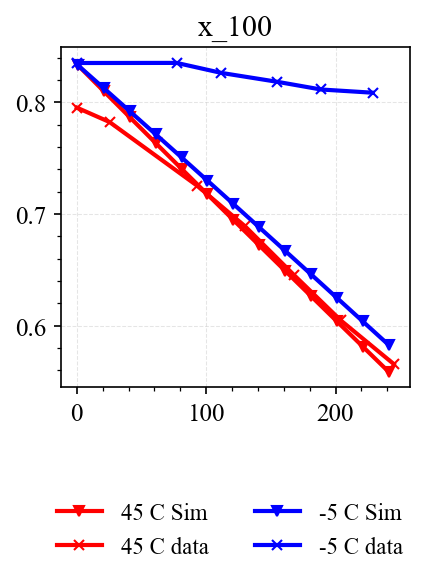

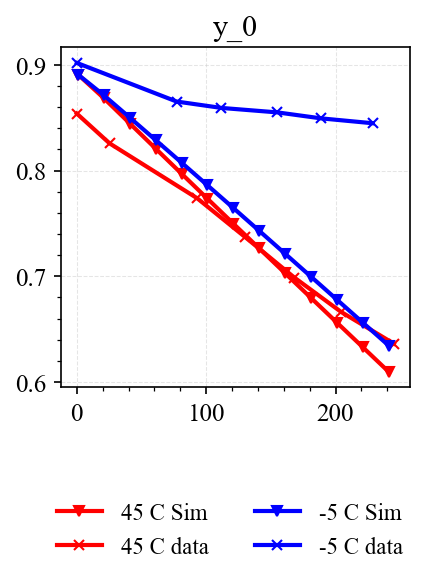

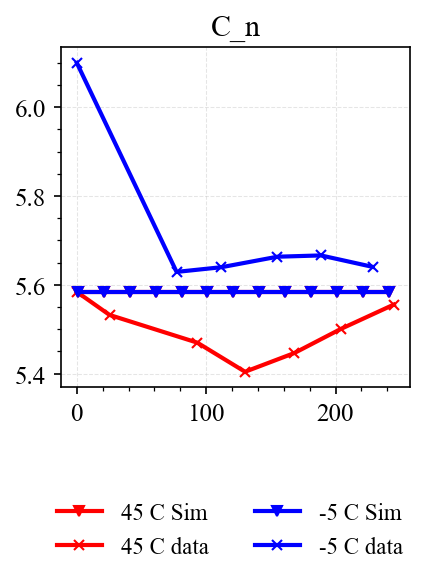

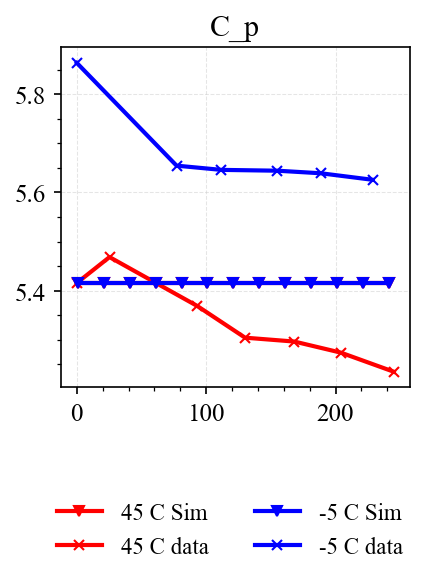

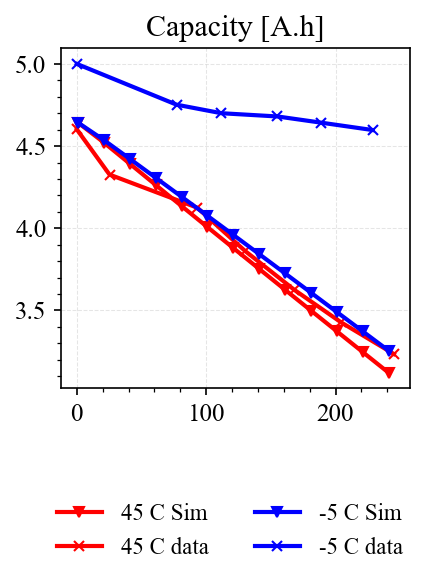

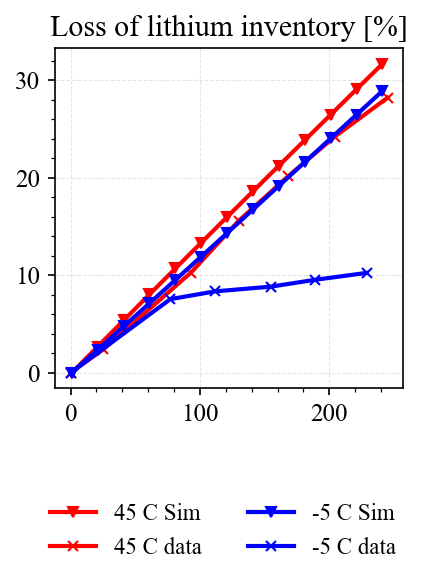

In [19]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI"]
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['k','r','b','g','c']
    # for k in range(len(dfl)):
    for k in [1,2]:
        ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[k],marker='v')
        ax.plot(dfe[k]['N'],dfe[k][esoh_vars[ev_num]],color=col[k],marker='x')
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    fig.legend(['45 C Sim','45 C data','-5 C Sim','-5 C data'], 
               loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=2, fontsize=11)
    plt.savefig(fig_DIR+'sens_comp_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

In [ ]:
vxcxc

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
for ev_num in range(len(esoh_vars)):
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    col = ['k','g','b','r','c']
    col_idx = [x // 2 +1 for x in range(-1,8)]
    mar_idx = [x % 2 for x in range(-1,8)]
    mar_idx[0]=2
    mar = [u'v',u'P',u'x']
    for k in range(len(dfl)):
        ax.plot(dfl[k]['Cycle number'],dfl[k][esoh_vars[ev_num]],color=col[col_idx[k]],marker=mar[mar_idx[k]])
        ax.set_title(split_long_string(esoh_vars[ev_num]))
    # fig.legend(Temp_s, 
    #            loc="lower center",bbox_to_anchor=[0.5,-0.3], ncol=3, fontsize=11)
    plt.savefig(fig_DIR+'sens_T_{0}_k_{1}_D_{2}'.format(Temp_idx,ksei_idx,dsei_idx)+'_comp_'+esoh_vars_str[ev_num]+'.png')

# Calculate RMSE

In [ ]:
esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]","Local ECM resistance [Ohm]","X-averaged SEI thickness [m]"]
esoh_vars_str = ["x_100", "y_0", "C_n", "C_p", "cap", "LLI","res","sei"]
for ev_num in range(len(esoh_vars)):
    print([esoh_vars[ev_num]])
    rmse_stats = []
    for k in range(len(dfl)):
        rmse_t=((dfl_m[k][esoh_vars[ev_num]] - df_base[esoh_vars[ev_num]]) ** 2).mean() ** .5
        rmse_stats.append(rmse_t)
    print(rmse_stats)